In [1]:
"""
A model worker executes the model.
"""

import uuid
import os
import re
import io
import argparse
import torch
import numpy as np
from PIL import Image
from tool_server.utils.utils import *
from tool_server.utils.server_utils import *
import matplotlib.pyplot as plt
from tool_server.tool_workers.online_workers.base_tool_worker import BaseToolWorker
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

2025-04-25 13:09:49 | ERROR | ipykernel.comm | No such comm target registered: jupyter.widget.control
2025-04-25 13:09:49 | WARNING | Comm | No such comm: aba54e79-4317-46c7-99d4-defaa5d9fe45
2025-04-25 13:21:53 | INFO | root | Loaded checkpoint sucessfully
2025-04-25 13:21:57 | INFO | root | Computing image embeddings for the provided image...
2025-04-25 13:22:01 | INFO | root | Image embeddings computed.
2025-04-25 13:22:01 | ERROR | stderr | /mnt/petrelfs/songmingyang/code/reasoning/ref/sam2/sam2/sam2_image_predictor.py:314: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
2025-04-25 13:22:01 | ERROR | stderr |   point_coords = torch.as_tensor(


In [2]:
def extract_points(generate_param, image_w, image_h):
    all_points = []
    pattern = r'x\d*=\s*\\?"?([0-9]+(?:\.[0-9]*)?)\\?"?\s*y\d*=\s*\\?"?([0-9]+(?:\.[0-9]*)?)\\?"?'
    
    for match in re.finditer(pattern, generate_param):
        try:
            point = [float(match.group(i)) for i in range(1, 3)]
        except ValueError:
            continue
        else:
            point = np.array(point)
            if np.max(point) > 100:
                continue
            point /= 100.0
            point = point * np.array([image_w, image_h])
            all_points.append(point)
    
    return all_points


def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))
    
def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    fig, ax = plt.subplots()
    ax.imshow(image)
    image_format = image.format.lower() if image.format else 'png'
    if image_format not in ['png', 'jpeg', 'jpg']:
        image_format = 'png'
    
    for i, (mask, score) in enumerate(zip(masks, scores)):
        show_mask(mask, ax, borders=borders)
        if len(scores) > 1:
            ax.set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    
    if point_coords is not None and input_labels is not None:
        show_points(point_coords, input_labels, ax)
    
    if box_coords is not None:
        show_box(box_coords, ax)
    
    plt.axis('off')
    
    buf = BytesIO()
    plt.savefig(buf, format=image_format, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.close(fig)
    buf.seek(0)
    
    edited_image = Image.open(buf).convert("RGB")
    
    return edited_image


In [6]:
model_cfg = "/mnt/petrelfs/songmingyang/songmingyang/model/mm/tools/sam2-hiera-large/sam2_hiera_l.yaml"
model_cfg = "sam2_hiera_l.yaml"
sam2_checkpoint = "//mnt/petrelfs/songmingyang/songmingyang/model/mm/tools/sam2-hiera-large/sam2_hiera_large.pt"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

In [7]:
imput_image_path = "/mnt/petrelfs/songmingyang/code/reasoning/tool-agent/tool_server/tool_workers/online_workers/test_cases/mathvista_35.jpg"
generate_param = ' <point x="66.2" y="71.5" alt="Point E">Point E</point>'

image = Image.open(imput_image_path).convert("RGB")
width, height = image.size
predictor.set_image(image)

points = extract_points(generate_param, width, height)

input_labels = np.ones(len(points))
masks, scores, _ = predictor.predict(
    point_coords=points,
    point_labels=input_labels,
    box=None,
    multimask_output=False,
)

edited_img = show_masks(image, masks, scores, point_coords=np.array(points), input_labels=input_labels)


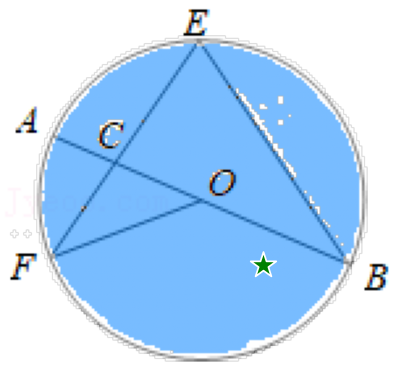

In [8]:
edited_img

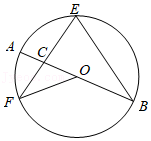

In [9]:
image